# Quantization Modes


In [88]:
# define imports
import numpy as np
from pathlib import Path

from quantization_notes.utils.utils import plot_table

OUTPUT_DIR = Path("../output")

## Symmetric Quantization

In symmetric quantization, we map the floating-point range to the quantized range with respect to $0$ - think along the lines of $[-100,100]$. To do so, we choose $\alpha = \max|x_f| = -\max(x_f)$ and $\max(x_f)$, where $x_f$ is some number in the floating-point range. 

Additionally, we choose $N_{bins} = 2^n$, where $n$ is the number of bits we want to quantize to. In order to derive our quantization range with respect to $0$, we simply place half the bins before $0$ and the other half after $0$.

Example: Let's say we wanted an 8-bit quantization range. Then, the number of bins would be $N_{bins} = 2^8 = 256 \implies [0,255] \implies [-128,127]$. That is the "full range" symmetric around 0. However in practice, this range is generally "restricted" to $[-127,127]$. We can derive scaling factors to map from floating point to quantized for both ranges:

$$
\def\arraystretch{1.5}
\begin{array}{c|c|c}
& \text{Full Range} & \text{Restricted Range} \\ \hline
\text{Quantized Range} & [-\frac{N_{bins}}{2},\frac{N_{bins}}{2}-1] & [-(\frac{N_{bins}}{2}-1),\frac{N_{bins}}{2}-1] \\ \hline
\text{8-bit Example} & [-128,127] & [-127,127] \\ \hline
\text{Scale Factor} & q_x=\frac{(2^n-1)/2}{\alpha} & q_x=\frac{2^{n-1}-1}{\alpha} \\
\end {array}
$$

Finally, we can compute our symmetric quantized tensor:

$$x_q = \text{round}(q_xx_f)$$


In [89]:
def quantize_symmetric_full(n: int, x_f: np.array) -> tuple[float, np.array]:
    q_x = ((pow(2, n) - 1) / 2) / np.max(np.abs(x_f))
    x_q = np.round(q_x * x_f)
    return q_x, x_q


def quantize_symmetric_restricted(n: int, x_f: np.array) -> tuple[float, np.array]:
    q_x = (pow(2, n - 1) - 1) / np.max(np.abs(x_f))
    x_q = np.round(q_x * x_f)
    return q_x, x_q


data = np.random.uniform(-1000, 1000, size=(5, 5))
print(f"unquantized data:\n {data} \n")

quantized_symmetric_full_scale, quantized_symmetric_full_data = quantize_symmetric_full(8, data)
print(f"quantize symmetric full\n {quantized_symmetric_full_data} \n")

quantized_symmetric_restricted_scale, quantized_symmetric_restricted_data = quantize_symmetric_restricted(8, data)
print(f"quantize symmetric restricted\n {quantized_symmetric_restricted_data} \n")

unquantized data:
 [[ -35.79577776  397.45174672  156.29697046 -905.50485156  442.37702283]
 [ 329.19361768 -126.00114866  824.11621767  379.71110684  901.71586037]
 [ 815.95248254 -374.28941289  339.9539027   -93.23749648  138.26987543]
 [ 512.06621322 -760.93464018 -329.99678561  806.846435    357.00014008]
 [ 979.28865502 -844.12915291 -613.60843388 -776.08148148   50.16212043]] 

quantize symmetric full
 [[  -5.   52.   20. -118.   58.]
 [  43.  -16.  107.   49.  117.]
 [ 106.  -49.   44.  -12.   18.]
 [  67.  -99.  -43.  105.   46.]
 [ 128. -110.  -80. -101.    7.]] 

quantize symmetric restricted
 [[  -5.   52.   20. -117.   57.]
 [  43.  -16.  107.   49.  117.]
 [ 106.  -49.   44.  -12.   18.]
 [  66.  -99.  -43.  105.   46.]
 [ 127. -109.  -80. -101.    7.]] 



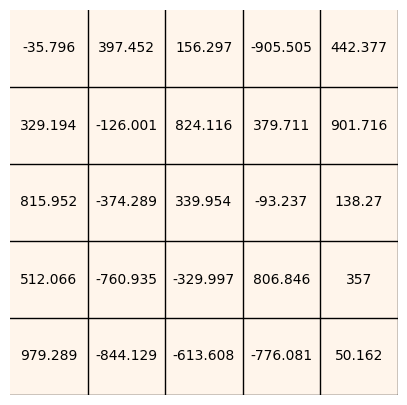

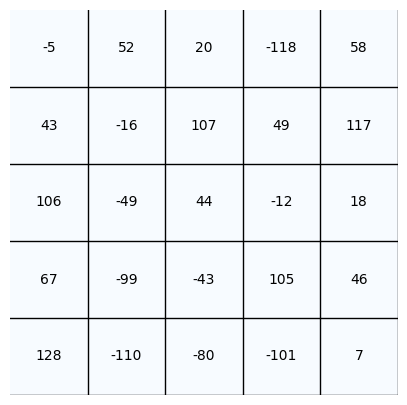

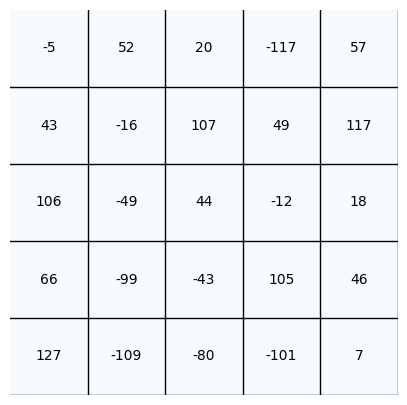

In [90]:
plot_table(data, str(OUTPUT_DIR / "unquantized-data.png"), "Oranges", "black", "black")
plot_table(
    quantized_symmetric_full_data,
    str(OUTPUT_DIR / "quantized-symmetric-full.png"),
    "Blues",
    "black",
    "black",
)
plot_table(
    quantized_symmetric_restricted_data,
    str(OUTPUT_DIR / "quantized-symmetric-restricted.png"),
    "Blues",
    "black",
    "black",
)

## Asymmetric Quantization

Compared to symmetric quantization, asymmetric also known as *affine* quantization has a few key differences:

- Instead of mapping the floating point range $[-\alpha, \alpha]$ to some quantized range symmetric to $0$, we choose $[\alpha, \beta]$, where $\alpha=\min(x_f)$ and $\beta=\max(x_f)$
- Since the mapping is no longer symmetric to $0$, we have to introduce a **zero-point** $z_{x}$ also known as *quantization bias*. This serves to actually represent $0$ in the quantized range.
- Additionally, the quantized range is now represented by $[0,2^n-1]$.

We can derive a scaling factor for asymmetric quantization:

$$
\def\arraystretch{1.5}
\begin{array}{c|c}
\text{Quantized Range} & [0,2^n-1] \\ \hline
\text{8-bit Example} & [0, 255] \\ \hline
\text{Scale Factor} & q_x=\frac{2^n-1}{\beta-\alpha} \\
\end {array}
$$

To find the zero-point $z_{x}$, simply take the minimum value of $x_f$ i.e. $\alpha$ and scale it to its representation in the new quantized range, which is:

$$
z_x = \text{round}(q_x\alpha)
$$

Finally, we can compute our asymmetric quantized tensor $q_x$ adjusted for bias:

$$
x_q = \text{round}(q_xx_f-z_x)
$$

-905.5048515588649 979.2886550224957
0.13529333537577765
-123.0
quantize asymmetric 
 [[118. 177. 144.   0. 183.]
 [168. 106. 234. 174. 245.]
 [233.  72. 169. 110. 142.]
 [192.  20.  78. 232. 171.]
 [255.   9.  40.  18. 130.]] 



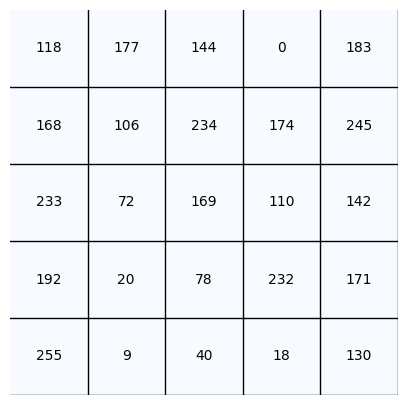

In [91]:
def quantize_asymmetric(n: int, x_f: np.array) -> tuple[float, float, np.array]:
    alpha = np.min(x_f)
    beta = np.max(x_f)
    print(alpha, beta)
    q_x = (pow(2,n)-1)/(beta-alpha)
    print(q_x)
    zero_point = np.round(q_x*alpha)
    print(zero_point)

    x_q = np.round(q_x*x_f-zero_point)

    return q_x, zero_point, x_q

quantized_asymmetric_scale, quantized_asymmetric_zero_point, quantized_asymmetric_data = quantize_asymmetric(8, data)
print(f"quantize asymmetric \n {quantized_asymmetric_data} \n")

plot_table(
    quantized_asymmetric_data,
    str(OUTPUT_DIR / "quantized-asymmetric.png"),
    "Blues",
    "black",
    "black",
)

## Dequantization and Error

Dequantization of a symmetric quantization is as simple as computing the quotient of the quantized tensor $x_q$ and the scale factor $q_x$:

$$\hat{x_f} = \frac{x_q}{q_x}$$ 

Similarly, dequantization of an asymmetric quantization is as follows:

$$\hat{x_f} = \frac{x_q+z_x}{q_x}$$ 

However as expected, there is some error associated with the process of quantizing a tensor and then dequantizing it. We can compute that error using mean-squared error (MSE):

$$
\text{MSE} = \frac{1}{n}\displaystyle\sum(\hat{x_f}-x_f)^2
$$


In [92]:
def dequantize_symmetric(q_x: float, x_q: np.array) -> np.array:
    return x_q / q_x

def dequantize_asymmetric(q_x: float, zero_point: float, x_q: np.array) -> np.array:
    return (x_q + zero_point) / q_x

def mse(a: np.array, b: np.array) -> float:
    return np.mean((a-b)**2)

dequantized_symmetric_full_data = dequantize_symmetric(quantized_symmetric_full_scale, quantized_symmetric_full_data)
dequantized_symmetric_full_error = mse(dequantized_symmetric_full_data, data)

print(f"dequantized symmetric full data: \n {dequantized_symmetric_full_data} \n")
print(f"dequantized symmetric full error: \n {dequantized_symmetric_full_error:.2}% \n")

dequantized_symmetric_restricted_data = dequantize_symmetric(quantized_symmetric_restricted_scale, quantized_symmetric_restricted_data)
dequantized_symmetric_restricted_error = mse(dequantized_symmetric_restricted_data, data)

print(f"dequantized symmetric restricted data: \n {dequantized_symmetric_restricted_data} \n")
print(f"dequantized symmetric restricted error: \n {dequantized_symmetric_restricted_error:.2}% \n")

dequantized_asymmetric_data = dequantize_asymmetric(quantized_asymmetric_scale, quantized_asymmetric_zero_point, quantized_asymmetric_data)
dequantized_asymmetric_error= mse(dequantized_asymmetric_data, data)

print(f"dequantized asymmetric data: \n {dequantized_asymmetric_data} \n")
print(f"dequantized asymmetric error: \n {dequantized_asymmetric_error:.2}% \n")



dequantized symmetric full data: 
 [[ -38.40347667  399.39615734  153.61390667 -906.32204935  445.48032934]
 [ 330.26989934 -122.89112534  821.83440069  376.35407134  898.64135402]
 [ 814.15370535 -376.35407134  337.95059467  -92.168344    138.252516  ]
 [ 514.60658735 -760.38883802 -330.26989934  806.47301002  353.31198534]
 [ 983.12900269 -844.87648669 -614.45562668 -775.75022868   53.76486733]] 

dequantized symmetric full error: 
 5.1% 

dequantized symmetric restricted data: 
 [[ -38.55467146  400.96858316  154.21868583 -902.17931211  439.52325462]
 [ 331.57017454 -123.37494866  825.06996919  377.83578028  902.17931211]
 [ 817.3590349  -377.83578028  339.28110883  -92.5312115   138.79681725]
 [ 508.92166324 -763.38249486 -331.57017454  809.64810061  354.70297741]
 [ 979.28865502 -840.49183778 -616.87474332 -778.80436344   53.97654004]] 

dequantized symmetric restricted error: 
 6.2% 

dequantized asymmetric data: 
 [[ -36.95673542  399.13274257  155.21828878 -909.13569141  443.48